In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, optimizers, initializers,Input,metrics
from tensorflow.keras.models import Model

from sklearn import preprocessing
from scipy.stats import wasserstein_distance
import math

tf.keras.backend.set_floatx('float64')

## Transform Data

In [44]:
df = pd.read_csv('train.csv')
del df['id']
print("Old shape:",df.shape)
df.dropna(inplace=True)
print("New shape:",df.shape)
df.tail()

Old shape: (381109, 11)
New shape: (381109, 11)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


In [45]:
columns = list(zip(df.columns,df.dtypes))
cat_columns = list(filter(lambda x: x[1] == object,columns))
cat_columns = [c[0] for c in cat_columns]

In [46]:
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore',sparse=False)
encoder.fit(df[cat_columns])
transformed = encoder.transform(df[cat_columns])
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = [" ".join(x.split('_')[1:]) for x in encoder.get_feature_names()]
df = pd.concat([df, ohe_df], axis=1).drop(cat_columns, axis=1)

In [47]:
scaler = preprocessing.MinMaxScaler()
num_columns = list(filter(lambda x: x not in ohe_df.columns,df.columns))
df[num_columns] = scaler.fit_transform(df[num_columns])

In [48]:
df.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Female,Male,1-2 Year,< 1 Year,> 2 Years,No,Yes
0,0.369231,1.0,0.538462,0.0,0.070366,0.154321,0.716263,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.861538,1.0,0.057692,0.0,0.057496,0.154321,0.598616,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.415385,1.0,0.538462,0.0,0.066347,0.154321,0.058824,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.015385,1.0,0.211538,1.0,0.048348,0.932099,0.667820,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.138462,1.0,0.788462,1.0,0.046259,0.932099,0.100346,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


## Auto Encoder

In [49]:
latent_dim = 8 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(latent_dim, activation='relu',
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      bias_initializer=initializers.Zeros())
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(df.shape[1], activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [50]:
autoencoder = Autoencoder(latent_dim)

opt = optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError(), 
                    metrics = [tf.keras.metrics.CosineSimilarity(axis=1),tf.keras.metrics.LogCoshError(),tf.keras.metrics.KLDivergence()])

In [51]:
split = int(df.shape[0]*0.8) 
x_train = df.iloc[:split].to_numpy()
x_test = df.iloc[split:].to_numpy()

In [589]:
_ = autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                batch_size=4096)

Epoch 1/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0022 - cosine_similarity: 0.9972 - logcosh: 0.0011 - kullback_leibler_divergence: 0.8212
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0021 - cosine_similarity: 0.9973 - logcosh: 0.0010 - kullback_leibler_divergence: 0.8196
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0021 - cosine_similarity: 0.9973 - logcosh: 0.0010 - kullback_leibler_divergence: 0.8189
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0021 - cosine_similarity: 0.9973 - logcosh: 0.0010 - kullback_leibler_divergence: 0.8189
Epoch 5/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0021 - cosine_similarity: 0.9974 - logcosh: 9.9882e-04 - kullback_leibler_divergence: 0.8143
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0021 - cosine_similarity: 0.9974 - logcosh: 0.0010 - kullback_leibler_divergence: 0.8175
Epoch 7/20
75/75 [

In [590]:
encoded_data = autoencoder.encoder(x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [591]:
results = autoencoder.evaluate(x_test,x_test,verbose=0)
print("MSE: ",results[0])
print("Cosine Similarity: ",results[1])
print("LogCosh: ",results[2])
print("KL Divergence: ",results[3])

MSE:  0.0019186843972917463
Cosine Similarity:  0.9975756641415603
LogCosh:  0.0009313031164652626
KL Divergence:  0.8108491728395446


## Variational Autoencoder

In [52]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [53]:
latent_dim = 2

encoder_inputs = Input(shape=df.shape[1])
x = layers.Dense(16, activation="sigmoid",kernel_initializer=initializers.RandomNormal(stddev=0.01),
      bias_initializer=initializers.Zeros())(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 16)           256         ['input_5[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            34          ['dense_13[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            34          ['dense_13[0][0]']               
                                                                                            

In [54]:
latent_inputs = Input(shape=latent_dim)
x = layers.Dense(16, activation="sigmoid",
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      bias_initializer=initializers.Zeros())(latent_inputs)
decoder_outputs = layers.Dense(df.shape[1], activation="sigmoid")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_14 (Dense)            (None, 16)                48        
                                                                 
 dense_15 (Dense)            (None, 15)                255       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [55]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = losses.mae(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [56]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam(0.005))

Epoch 1/10
75/75 [==============================] - 1s 14ms/step - loss: 0.2908 - reconstruction_loss: 0.2910 - kl_loss: 9.2375e-08
Epoch 2/10
75/75 [==============================] - 1s 14ms/step - loss: 0.2915 - reconstruction_loss: 0.2910 - kl_loss: 6.4324e-07
Epoch 3/10
75/75 [==============================] - 1s 15ms/step - loss: 0.2908 - reconstruction_loss: 0.2910 - kl_loss: 8.7184e-07
Epoch 4/10
75/75 [==============================] - 1s 15ms/step - loss: 0.2909 - reconstruction_loss: 0.2910 - kl_loss: 2.9855e-07
Epoch 5/10
75/75 [==============================] - 1s 14ms/step - loss: 0.2914 - reconstruction_loss: 0.2910 - kl_loss: 3.8581e-06
Epoch 6/10
75/75 [==============================] - 1s 14ms/step - loss: 0.2910 - reconstruction_loss: 0.2910 - kl_loss: 9.4933e-08
Epoch 7/10
75/75 [==============================] - 1s 14ms/step - loss: 0.2905 - reconstruction_loss: 0.2910 - kl_loss: 4.1184e-06
Epoch 8/10
75/75 [==============================] - 1s 15ms/step - loss: 0.2

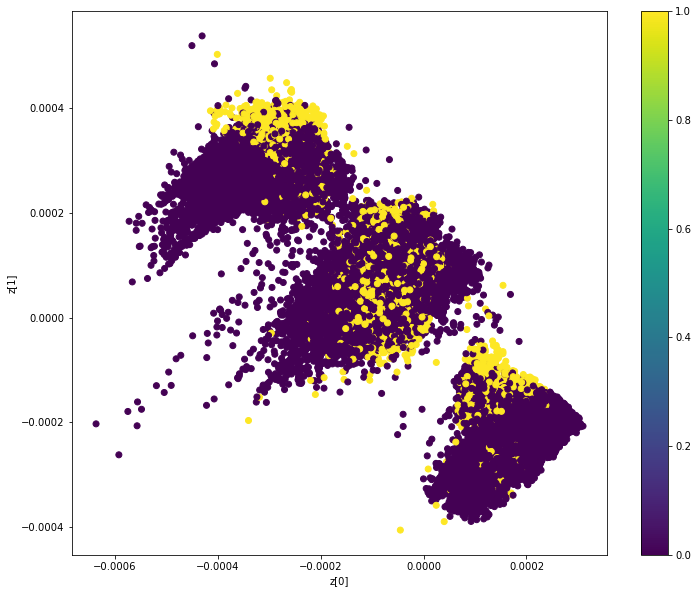

In [58]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
vae.fit(x_train, epochs=10, batch_size=4096)
lim = 100000
plot_label_clusters(vae, x_test[:], x_test[:,7])

In [83]:
x_test[1007]

array([0.47692308, 1.        , 0.53846154, 0.        , 0.        ,
       0.94444444, 0.8615917 , 1.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ])

In [84]:
_,_,sample = vae.encoder.predict(np.array([x_test[1007]]))

In [85]:
vae.decoder.predict(sample)

array([[2.45169121e-01, 9.99982639e-01, 5.35947077e-01, 1.80162182e-05,
        5.49814752e-02, 8.11012664e-01, 4.92618510e-01, 1.74850401e-05,
        1.46821901e-05, 9.99987851e-01, 9.99986898e-01, 1.48800055e-05,
        1.65901350e-05, 5.10423012e-05, 9.99970857e-01]])

## Generative Adverserial Networks

In [15]:
class GAN(Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.rows = df.shape[1]
        self.latent_dim = 32

        self.discriminator = self.build_discriminator()
        self.discriminator.summary()
        self.generator = self.build_generator()
        self.generator.summary()
        
        # Instantiate one optimizer for the discriminator and another for the generator.
        self.d_optimizer = optimizers.Adam(learning_rate=0.0001)
        self.g_optimizer = optimizers.Adam(learning_rate=0.0001)

        
        self.des_loss_tracker = metrics.Mean(name="discriminator_loss")
        self.gen_loss_tracker = metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [
            self.gen_loss_tracker,
            self.des_loss_tracker,
        ]


    def build_generator(self):
        encoder_inputs = Input(shape=self.latent_dim)
        x = layers.Dense(16, activation="sigmoid",kernel_initializer=initializers.RandomNormal(stddev=0.1),
              bias_initializer=initializers.Zeros())(encoder_inputs)
        gen_outputs = layers.Dense(self.rows,activation='relu')(x)
        model = Model(encoder_inputs, gen_outputs, name="generator")
        
        return model

    def build_discriminator(self):

        latent_inputs = Input(shape=self.rows)
        x = layers.Dense(16, activation="relu",
        kernel_initializer=initializers.RandomNormal(stddev=0.1),
          bias_initializer=initializers.Zeros())(latent_inputs)
        decoder_outputs = layers.Dense(1, activation="relu")(x)
        model = Model(latent_inputs, decoder_outputs, name="discriminator")

        return model
    
    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            noise = np.random.normal(0, 1, (1,self.latent_dim))
            gen_samples = self.generator(noise)
            pred = self.discriminator(data)
            d_loss_real = losses.binary_crossentropy(np.array([1]).reshape((-1,1)), pred, from_logits=True)
            pred = self.discriminator(gen_samples)
            d_loss_fake = losses.binary_crossentropy(np.array([0]).reshape((-1,1)), pred, from_logits=True)
            d_loss = 0.5 * (d_loss_fake + d_loss_real)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        self.des_loss_tracker.update_state(d_loss)
        
        with tf.GradientTape() as tape:
            noise = np.random.normal(0, 1, (1,self.latent_dim))
            gen_samples = self.generator(noise)
            pred = self.discriminator(gen_samples)
            d_loss_fake = losses.binary_crossentropy(np.array([0]).reshape((-1,1)), pred, from_logits=True)
            
        grads = tape.gradient(d_loss_fake, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.gen_loss_tracker.update_state(d_loss_fake)
        
        
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "dis_loss": self.des_loss_tracker.result(),
        }

In [16]:
gan = GAN()
gan.compile()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_6 (Dense)             (None, 16)                256       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_8 (Dense)             (None, 

In [ ]:
gan.fit(x_train,epochs=500,batch_size=4096)

Epoch 1/500
75/75 [==============================] - 3s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.6781
Epoch 2/500
75/75 [==============================] - 1s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.6559
Epoch 3/500
75/75 [==============================] - 1s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.6290
Epoch 4/500
75/75 [==============================] - 1s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.6011
Epoch 5/500
75/75 [==============================] - 1s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.5739
Epoch 6/500
75/75 [==============================] - 1s 8ms/step - gen_loss: 0.6931 - dis_loss: 0.5475
Epoch 7/500
75/75 [==============================] - 1s 9ms/step - gen_loss: 0.6931 - dis_loss: 0.5208
Epoch 8/500
75/75 [==============================] - 1s 9ms/step - gen_loss: 0.6931 - dis_loss: 0.4997
Epoch 9/500
75/75 [==============================] - 1s 7ms/step - gen_loss: 0.6931 - dis_loss: 0.4822
Epoch 10/500
40/75 [===============>..............] - ETA: 0s - gen_loss:

In [36]:
gan.generator.predict(np.random.normal(0, 1, (1,8)))

array([[0.        , 0.        , 0.        , 0.        , 0.02689842,
        1.74486597, 0.        , 0.11037312, 0.01701864, 0.        ,
        0.        , 1.05611983, 0.        , 0.07364678, 0.        ]])

In [531]:
x_test[100]

array([0.4       , 1.        , 0.57692308, 1.        , 0.07786098,
       0.15432099, 0.34256055, 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ])

## Another Implementation of GAN
Above implementation works on single sample which converges but is not giving appropriate output. This one works on batch.

In [10]:
shape = (df.shape[1])

discriminator = tf.keras.Sequential(
    [
        Input(shape=shape),
        layers.Dense(16),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(16),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                256       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [11]:
latent_dim = 8

generator = tf.keras.Sequential(
    [
        Input(shape=(latent_dim,)),
        layers.Dense(16),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(16),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(shape,activation='relu')
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 15)                255       
                                                                 
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [12]:

# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = optimizers.Adam(learning_rate=0.0001)
g_optimizer = optimizers.Adam(learning_rate=0.0001)

# Instantiate a loss function.
loss_fn = losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_samples):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_samples = generator(random_latent_vectors)
    # Combine them with real images
    combined_samples = tf.concat([generated_samples, real_samples], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_samples.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.1 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_samples)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_samples

In [13]:

batch_size = 16000
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 100

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real in enumerate(dataset):
        d_loss, g_loss, samples = train_step(real)

        # Logging.
        if step % 1000 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss),end="\t")
            print("adversarial loss at step %d: %.2f" % (step, g_loss))


Start epoch 0
discriminator loss at step 0: 0.69	adversarial loss at step 0: 0.79

Start epoch 1
discriminator loss at step 0: 0.69	adversarial loss at step 0: 0.78

Start epoch 2
discriminator loss at step 0: 0.69	adversarial loss at step 0: 0.77

Start epoch 3
discriminator loss at step 0: 0.68	adversarial loss at step 0: 0.76

Start epoch 4
discriminator loss at step 0: 0.68	adversarial loss at step 0: 0.75

Start epoch 5
discriminator loss at step 0: 0.68	adversarial loss at step 0: 0.74

Start epoch 6
discriminator loss at step 0: 0.68	adversarial loss at step 0: 0.73

Start epoch 7
discriminator loss at step 0: 0.68	adversarial loss at step 0: 0.72

Start epoch 8
discriminator loss at step 0: 0.67	adversarial loss at step 0: 0.71

Start epoch 9
discriminator loss at step 0: 0.67	adversarial loss at step 0: 0.70

Start epoch 10
discriminator loss at step 0: 0.67	adversarial loss at step 0: 0.70

Start epoch 11
discriminator loss at step 0: 0.67	adversarial loss at step 0: 0.69

S


Start epoch 98
discriminator loss at step 0: 0.69	adversarial loss at step 0: 0.80

Start epoch 99
discriminator loss at step 0: 0.69	adversarial loss at step 0: 0.81


### Actual

In [531]:
x_test[100]

array([0.4       , 1.        , 0.57692308, 1.        , 0.07786098,
       0.15432099, 0.34256055, 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ])

### Generated

In [76]:
random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
generator(random_latent_vectors)

<tf.Tensor: shape=(1, 15), dtype=float64, numpy=
array([[1.33314464, 2.29857554, 0.06297643, 0.        , 0.        ,
        0.        , 0.70562989, 0.94235866, 1.13107387, 0.        ,
        1.6038412 , 0.        , 0.        , 1.50398833, 0.99558227]])>